# **Simple GAN to generate music**

## Imports and constant params

In [0]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras import models, Model
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

NOTE_MIN = 53
NOTE_MAX = 93
DOWNLOAD = True

In [0]:
tf.__version__

'1.14.0'

## Retrieve data 
Can be uploaded directly to the notebook or downloaded from dropbox

In [0]:
dropbox_link = "https://www.dropbox.com/s/72b7bsjxbe3ibxc/June_Fixes_Notes.npy?dl=0"
if DOWNLOAD or datafile is None:
  dropbox_link = dropbox_link.replace("www.dropbox.com", "dl.dropboxusercontent.com", 1)
  import requests, zipfile, io, os
  r = requests.get(dropbox_link)
  datafile = io.BytesIO(r.content)
  print("Download complete")

Download complete


In [0]:
# data = np.load("{}.npy".format('June_Fixes_Notes'),  allow_pickle=True) # if uploaded
raw_data = np.load(datafile, allow_pickle=True) # if downloaded

In [0]:
print("Loaded data")
print("Shape: {}".format(raw_data.shape))
print("First Entry:", end="\n\n")
print(raw_data[2])

Loaded data
Shape: (3468,)
First Entry:

[[81 81 79 79  0  0  0  0  0  0  0  0  0  0  0  0]
 [78 78 81 81 76 76 78 78 74 74 76 76 69 69 66 66]
 [62 62 66 66 69 69 74 74 78 78 78 78 76 76 78 78]
 [79 79 83 83 76 76 79 79 74 74 76 76 69 69 66 66]
 [67 67 71 71 69 69 67 67 64 64 64 64 81 81 79 79]
 [78 78 81 81 76 76 78 78 74 74 76 76 69 69 66 66]
 [62 62 66 66 69 69 74 74 78 78 78 78 76 76 78 78]
 [79 79 78 78 76 76 74 74 72 72 69 69 71 71 72 72]
 [74 74 74 74 78 78 78 78 74 74 74 74 81 81 79 79]
 [78 78 81 81 76 76 78 78 74 74 76 76 69 69 66 66]
 [62 62 66 66 69 69 74 74 78 78 78 78 76 76 78 78]
 [79 79 83 83 76 76 79 79 74 74 76 76 69 69 66 66]
 [67 67 71 71 69 69 67 67 64 64 64 64 81 81 79 79]
 [78 78 81 81 76 76 78 78 74 74 76 76 69 69 66 66]
 [62 62 66 66 69 69 74 74 78 78 78 78 76 76 78 78]
 [79 79 78 78 76 76 74 74 72 72 69 69 71 71 72 72]
 [74 74 74 74 78 78 78 78 74 74 74 74 62 62 64 64]
 [67 67 66 66 67 67 69 69 71 71 72 72 74 74 76 76]
 [78 78 79 79 78 78 76 76 74 74 72 72 74 

## Reshape data

In [0]:
print("Old shape: {}".format(raw_data.shape))
numOfBars = np.array([tune.shape[0] for tune in raw_data])
# Tunes with a pickup bar, have the pickup bar padded
# with zeros to 16 notes.
notesPerBar = np.array([tune.shape[1] for tune in raw_data])
data = raw_data[(numOfBars >= 16) & (notesPerBar == 16)]

newdata = []

for index, tune in enumerate(data):
    if len(tune) == 16:
      newdata.append(tune.tolist())
    if len(tune) == 17:
      newdata.append(tune[1:].tolist())
    
data = newdata
data = np.array(data).reshape([-1, 4, 16*4])
data = np.clip(data, 0, 127) #subzero makes no sense

print(data[0])
print("Min/Max: ", data.min(), data.max())
print("New shape: {}".format(data.shape))

Old shape: (3468,)
[[74 74 74 74 74 74 72 72 74 74 69 69 65 65 69 69 74 74 74 74 74 74 72 72
  74 74 77 77 75 75 72 72 74 74 74 74 74 74 72 72 74 74 69 69 65 65 69 69
  67 67 65 65 63 63 65 65 67 67 69 69 70 70 72 72]
 [74 74 74 74 74 74 72 72 74 74 69 69 65 65 69 69 74 74 74 74 74 74 72 72
  74 74 77 77 75 75 79 79 77 77 74 74 75 75 72 72 74 74 69 69 65 65 69 69
  67 67 65 65 63 63 65 65 67 67 70 70 69 69 67 67]
 [65 65 62 62 69 69 62 62 70 70 62 62 69 69 62 62 65 65 62 62 69 69 62 62
  67 67 70 70 69 69 67 67 65 65 62 62 69 69 62 62 70 70 62 62 69 69 62 62
  67 67 65 65 63 63 65 65 67 67 70 70 69 69 67 67]
 [65 65 62 62 69 69 62 62 70 70 62 62 69 69 62 62 65 65 62 62 69 69 62 62
  67 67 70 70 69 69 67 67 65 65 69 69 74 74 77 77 75 75 72 72 74 74 69 69
  67 67 65 65 63 63 65 65 67 67 69 69 70 70 72 72]]
Min/Max:  0 93
New shape: (1076, 4, 64)


In [0]:
tunes_nonzero = []
for tune in data:
  if np.any(tune<NOTE_MIN): continue
  tunes_nonzero.append(tune)
data = np.array(tunes_nonzero)
print(data.shape, data.min(), data.max())
print(data.mean())

(820, 4, 64) 53 93
74.54727991615853


In [0]:
# data = np.array(data).reshape([820, 256])
# data.shape
# data[0]


In [0]:
# indeces = [0, 16, 32, 64, 80, 96, 112, 128, 144, 160, 192, 208, 224, 240]
# fda = [54, 57, 62, 66, 69, 94, 78, 81, 86]

# yes = 0
# no = 0

# for dat in data:
#   count = 0
#   for i, note in enumerate(dat):
#     if i in indeces and note in fda:
#       count += 1
#   if count > len(indeces)/2:
#     yes += 1
#   else:
#     no += 1

# both = yes + no    
    
# print(100*yes/both, 100*no/both)

In [0]:
# data[0][-1][-1]

notefreq = {}
for dat in data:
  if dat[0][-4] in notefreq:
    notefreq[dat[0][-4]] += 1
  else:
    notefreq[dat[0][-4]] = 1

# 2 2 1 2 2 2 1
    
chars_as_num = {
    'F,': 54,
    'G,': 55,
    'A,': 57,
    'B,': 59,
    'C': 61,
    'D': 62,
    'E': 64,
    'F': 66,
    'G': 67,
    'A': 69,
    'B': 71,
    'c': 73,
    'd': 74,
    'e': 76,
    'f': 78,
    'g': 79,
    'a': 81,
    'b': 83,
    'c\'': 85,
    'd\'': 86,
    'e\'': 88,
    'f\'': 90
}

notes = {v:k for (k,v) in chars_as_num.items()}
print("In key:")
for k in range(data.min(), data.max()):
  if k in notes:
    if k in notefreq:
      print("\t{}: {:.2f}%".format(notes[k], 100*notefreq[k]/data.shape[0]))
    else:
      print("\t{}: {:.2f}%".format(notes[k], 0))
print("Not in key:")
notinkey = 0
for k in range(data.min(), data.max()):
  if k not in notes:
    if k in notefreq:
      notinkey += notefreq[k]
      print("\t{}: {:.2f}%".format(k, 100*notefreq[k]/data.shape[0]))
print("{}: {:.2f}%".format("Total out of key", 100*notinkey/data.shape[0]))  

In key:
	F,: 0.00%
	G,: 0.00%
	A,: 0.73%
	B,: 1.34%
	C: 0.00%
	D: 12.07%
	E: 3.90%
	F: 3.41%
	G: 1.83%
	A: 10.85%
	B: 8.41%
	c: 0.37%
	d: 27.56%
	e: 9.51%
	f: 4.88%
	g: 2.68%
	a: 4.02%
	b: 1.22%
	c': 0.00%
	d': 1.83%
	e': 0.12%
	f': 0.00%
Not in key:
	58: 0.24%
	60: 0.37%
	63: 0.85%
	65: 0.37%
	70: 0.24%
	72: 2.32%
	75: 0.24%
	80: 0.12%
	84: 0.49%
Total out of key: 5.24%


In [0]:
quarter = 0
eigth = 0
sixteenth = 0
quarterinkey = 0
eigthinkey = 0
sixteenthinkey = 0

for dat in data:
  if dat[-4][-1] == dat[-4][-4]:
    quarter += 1
    if dat[-4][-1] == 62 or dat[-4][-1] == 74:
      quarterinkey += 1
  elif dat[-4][-1] == dat[-4][-2]:
    eigth += 1
    if dat[-4][-4] == 62 or dat[-4][-4] == 74 or dat[-4][-2] == 62 or dat[-4][-2] == 74:
      eigthinkey += 1
  else:
    sixteenth += 1
    if dat[-4][-4] == 62 or dat[-4][-4] == 74 or dat[-4][-2] == 62 or dat[-4][-2] == 74 or dat[-4][-1] == 62 or dat[-4][-1] == 74:
      sixteenthinkey += 1
    
quarter = 100*quarter/data.shape[0]
eigth = 100*eigth/data.shape[0]
sixteenth = 100*sixteenth/data.shape[0]
quarterinkey = 100*quarterinkey/data.shape[0]
eigthinkey = 100*eigthinkey/data.shape[0]
sixteenthinkey = 100*sixteenthinkey/data.shape[0]
    
print("1/4: {:.2f}%\n1/8: {:.2f}%\n1/16: {:.2f}%".format(quarter, eigth, sixteenth))
print("\nIn key:\n1/4: {:.2f}% ({:.2f}%)\n1/8: {:.2f}% ({:.2f}%)\n1/16: {:.2f}% ({:.2f}%)".format(quarterinkey, 100*quarterinkey/quarter, eigthinkey, 100*eigthinkey/eigth, sixteenthinkey, 100*sixteenthinkey/sixteenth))

1/4: 37.44%
1/8: 62.07%
1/16: 0.49%

In key:
1/4: 21.95% (58.63%)
1/8: 22.56% (36.35%)
1/16: 0.24% (50.00%)


### Calculate variation across images

Mean Absolute Deviation:
Max: 5.61
Min: 4.32


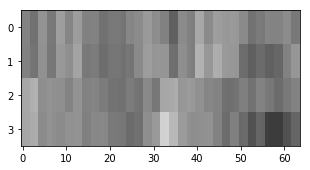

In [0]:
def calculateVariation(data, plotMin=None, plotMax=None):
  mad = np.abs(data - data.mean(axis=0)).mean(axis=0)
  print("Mean Absolute Deviation:")
  print("Max:", f"{mad.max():.2f}")
  print("Min:", f"{mad.min():.2f}")

  plt.figure(figsize=[5, 2.5])
  plt.imshow(mad, cmap='gray', aspect='auto', vmin=plotMin, vmax=plotMax)
  plt.show()
  
calculateVariation(data, plotMin=3.8, plotMax=6)

## Make GAN

In [0]:
class GAN():
    def __init__(self):
        self.img_dim = [4, 64] #RHS of sum is padding
        self.channels = 1
        self.img_shape = [*self.img_dim, self.channels]
        self.noise_shape = [100, ]

        self.gloss = []
        self.dloss = []
        self.intervals = []
        self.graphInterval = 50

        optimizer = optimizers.Adam()

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()

        noise = layers.Input(shape=self.noise_shape)
        img = self.generator(noise)

        self.discriminator.trainable = False

        valid = self.discriminator(img)

        self.combined = models.Model(inputs=noise, outputs=valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self, momentum=0.8, alpha_leak=0.2):
        noise_shape = self.noise_shape
        num_filters = 256
        model = models.Sequential()

        #dense in, reshape
        model.add(layers.Dense(self.img_dim[0]//2 * self.img_dim[1]//2 * num_filters, input_shape=noise_shape, activation = "selu"))
        model.add(layers.Reshape([(self.img_dim[0]//2),(self.img_dim[1]//2), num_filters*self.channels]))
    
        #conv 1
        model.add(layers.BatchNormalization(momentum=momentum))
        model.add(layers.Conv2DTranspose((num_filters//2)*self.channels, [2,5], padding="same", activation="selu")) #32 filters, each of the size of the input image
        
        #conv 2
        model.add(layers.BatchNormalization(momentum=momentum))
        model.add(layers.Conv2DTranspose((num_filters//4)*self.channels, [2,5], padding="same", activation="selu"))
        
        #conv final
        model.add(layers.BatchNormalization(momentum=momentum))
        model.add(layers.Conv2DTranspose(self.channels,strides=(2,2), kernel_size = [2,5], padding="same", activation="tanh")) #image

        model.summary()

        noise = layers.Input(shape=noise_shape)
        img = model(noise)
        return models.Model(noise, img)

    def build_discriminator(self, alpha_leak=0.2):
        img_shape = self.img_shape
        dropout_rate = .2
        n_filters = 64
        dense_out = 1024
        
        input_img = Input(shape=img_shape)

        t1 = layers.Conv2D(n_filters//2, (4,4), dilation_rate=(4,1), padding='same')(input_img) # beginning of 4 1/4 bars, across all phrases.
        t1 = layers.LeakyReLU(alpha=0.01)(t1)
        t2 = layers.Conv2D(n_filters//2, (4,4), dilation_rate=(8,1), padding='same')(input_img) # beginning of 4 1/2 bars, across all phrases.
        t2 = layers.LeakyReLU(alpha=0.01)(t2)
        t3 = layers.Conv2D(n_filters//2, (4,4), dilation_rate=(16,1), padding='same')(input_img) # beginning of every bar, across all phrases.
        t3 = layers.LeakyReLU(alpha=0.01)(t3)
        # updating towers t5 and t6 to look at phrases 1,2 and 3,4 instead
        t4 = layers.Conv2D(n_filters//2, (4,2), dilation_rate=(8, 2), padding='same')(input_img)
        t4 = layers.LeakyReLU(alpha=0.01)(t4)
        t5 = layers.Conv2D(n_filters//2, (4,2), dilation_rate=(16,2), padding='same')(input_img)
        t5 = layers.LeakyReLU(alpha=0.01)(t5)
        t6 = layers.Conv2D(n_filters//2, (2,9), padding='same')(input_img)
        t6 = layers.LeakyReLU(alpha=0.01)(t6)
        
#         t7 = layers.Conv2D(n_filters//2, (4,2), dilation_rate=(8, 1), padding='same')(input_img)
#         t7 = layers.LeakyReLU(alpha=0.01)(t7)
#         t8 = layers.Conv2D(n_filters//2, (4,2), dilation_rate=(16,1), padding='same')(input_img)
#         t8 = layers.LeakyReLU(alpha=0.01)(t8)
        
        tower_1 = layers.concatenate([t1, t2, t3, t4, t5, t6], axis=-1)
        
        x = layers.Conv2D(n_filters, [3,3], strides=[2,2], padding="valid")(tower_1)
        x = layers.LeakyReLU(alpha=0.1)(x)
        
        x = layers.Flatten()(x)
        x = layers.Dense(dense_out)(x)
        x = layers.LeakyReLU(alpha=0.01)(x)
        output = layers.Dense(1, activation="sigmoid")(x)
        model = Model(inputs=input_img, outputs=output)
        model.summary()  
        return model

    def train(self, iterations, batch_size=64, sample_interval=750):
        X_train = data
        halfMaxPitch = (NOTE_MAX+NOTE_MIN)//2
        pitchRange = NOTE_MAX - halfMaxPitch
        X_train = (X_train.astype(np.float32) - halfMaxPitch) / pitchRange
        X_train = np.expand_dims(X_train, axis=3)

        for iteration in range(iterations+1):
            for _ in range(1): #train discriminator more times
                discriminator_loss = self.train_discriminator(X_train, batch_size=batch_size)              
            generator_loss = self.train_generator(batch_size)

            if(iteration % self.graphInterval):
                self.dloss.append(discriminator_loss[0])
                self.gloss.append(generator_loss)
                self.intervals.append(iteration)

            if iteration % sample_interval == 0:
                display.clear_output(wait=True)    
                print("{} [D loss: {}, acc.: {:.2f}%] [G loss: {}]".format(
                    iteration,
                    discriminator_loss[0],
                    100 * discriminator_loss[1],
                    generator_loss))
                print(X_train[0][0][0:7] * 0.5 + 0.5)
                self.sample_images()

        #self.plotLossHistory()

    def train_discriminator(self, X_real, batch_size):
        half_batch = batch_size // 2

        discriminator_indices = np.random.randint(0, X_real.shape[0], half_batch)
        discriminator_train_imgs = X_real[discriminator_indices]

        noise = np.random.normal(0, 1, [half_batch, 100])
        generated_imgs = self.generator.predict(noise)

        discriminator_loss_real = self.discriminator.train_on_batch(discriminator_train_imgs, np.ones([half_batch, 1]))
        discriminator_loss_gen = self.discriminator.train_on_batch(generated_imgs, np.zeros([half_batch, 1]))
        # average the two losses
        discriminator_loss = np.add(discriminator_loss_real, discriminator_loss_gen) / 2

        return discriminator_loss

    def train_generator(self, batch_size):
        noise = np.random.normal(0, 1, [batch_size, 100])
        valid_y = np.array([1] * batch_size)  # move generator towards desired validity

        generator_loss = self.combined.train_on_batch(noise, valid_y)
        return generator_loss
      
    def plotLossHistory(self):
        plt.figure(figsize=[10,10])
        plt.plot(self.intervals, self.dloss)
        plt.plot(self.intervals, self.gloss)
        plt.legend(["Discriminator Loss", "Generator Loss"])
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.ylim(ymin=0, ymax=15)
        plt.show()

    def sample_images(self):
        rows, columns = 4, 4
        noise = np.random.normal(0, 1, [rows * columns, 100])
        
        generated_imgs = self.generator.predict(noise)
        generated_imgs = np.squeeze(generated_imgs, axis=3)
        generated_imgs = 0.5 * generated_imgs + 0.5
        
        print(generated_imgs[0][0][0:7])
        
        random_real_indices = np.random.randint(0, data.shape[0], rows*columns)
        real_imgs = data[random_real_indices]
                                        
        print("Real")
        fig, axs = plt.subplots(rows, columns, figsize=[10,10])
        for row in range(rows):
            for column in range(columns):
                count = row * columns + column
                axs[row, column].imshow(real_imgs[count, :, :], cmap='gray', aspect='auto')
                axs[row, column].axis('off')

        plt.show()
                                        
        print("Generated")
        fig, axs = plt.subplots(rows, columns, figsize=[10, 10])
        for row in range(rows):
            for column in range(columns):
                count = row * columns + column
                axs[row, column].imshow(generated_imgs[count, :, :], cmap='gray', aspect='auto')
                axs[row, column].axis('off')

        plt.show()
        self.plotLossHistory()


gan = GAN()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4, 64, 1)]   0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 4, 64, 32)    544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 4, 64, 32)    544         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 4, 64, 32)    544         input_1[0]

## Plot discriminator
I didn't know keras could do this until recently. Isn't it pretty?

In [0]:
#keras.utils.plot_model(gan.discriminator, show_shapes=True)

4000 [D loss: 0.06316041946411133, acc.: 98.44%] [G loss: 7.033755779266357]
[[0.525]
 [0.525]
 [0.525]
 [0.525]
 [0.525]
 [0.525]
 [0.475]]
[0.63196737 0.6330832  0.62906516 0.62873346 0.59902984 0.60463536
 0.52220553]
Real


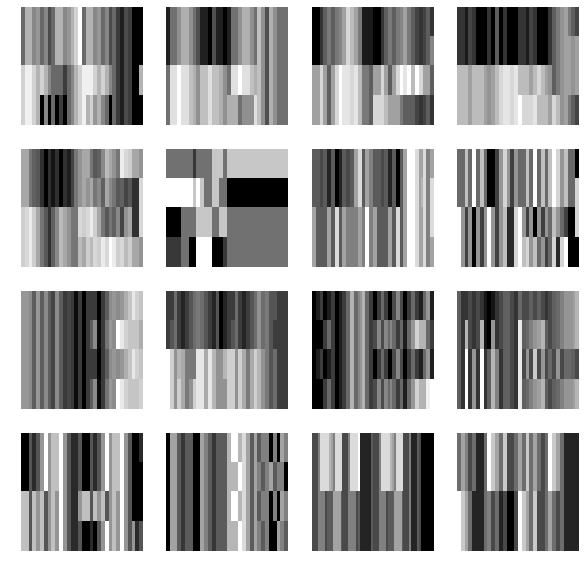

Generated


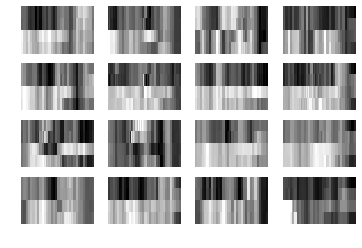

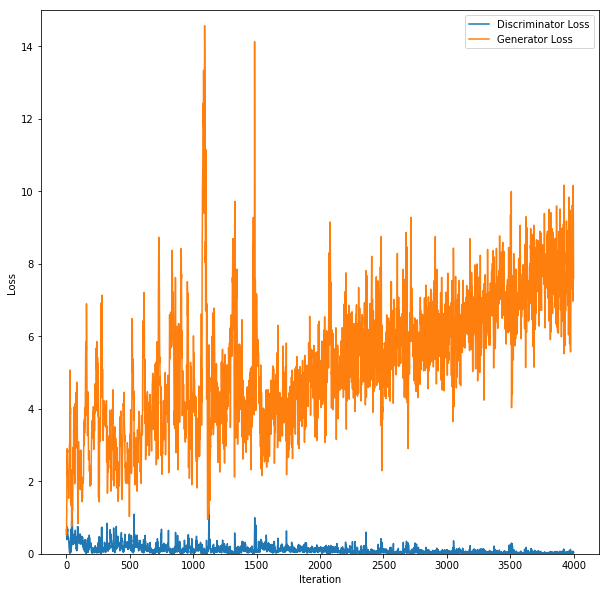

In [0]:
# with current settings it takes about ~5k iterations to get something decent
# It becomes prone to collapse fairly quickly after it produces decent results
iters = 4000
gan.train(iterations=iters, sample_interval=500, batch_size=64)

## Save model

In [0]:
gan.combined.save('combined.h5')
gan.generator.save('generator.h5')
gan.discriminator.save('discriminator.h5')

In [0]:
#Round output values to available values in D major
def samples_to_d_major(samples):
  
  def note_to_d_major(note):
    d_maj_values = np.array([62, 64, 66, 67, 69, 71, 73]) - 60 #C is now at 0
                            # D   E   F   G   A   B   C
    octave = note // 12
    noteInScale = note % 12

    noteDistances = np.abs(d_maj_values - noteInScale)
    roundedNote = d_maj_values[noteDistances.argmin()]
    return roundedNote + 12*octave
    
  note_to_d_major = np.vectorize(note_to_d_major)
  return note_to_d_major(samples).astype(np.int32)

In [0]:
chars_as_num = {
    'F,': 54,
    'G,': 55,
    'A,': 57,
    'B,': 59,
    'C,': 61,
    'D': 62,
    'E': 64,
    'F': 66,
    'G': 67,
    'A': 69,
    'B': 71,
    'C': 73,
    'd': 74,
    'e': 76,
    'f': 78,
    'g': 79,
    'a': 81,
    'b': 83,
    'c': 85,
    'd\'': 86,
    'e\'': 88,
    'f\'': 90
}

notes = {v:k for (k,v) in chars_as_num.items()}

In [0]:
gen = gan.generator
noise = np.random.normal(0, 1, [1000, 100])
samples = gen.predict(noise)
samples = np.squeeze(samples,-1)
halfMaxPitch = (NOTE_MAX+NOTE_MIN)//2
pitchRange = NOTE_MAX - halfMaxPitch
# print(samples[0][0])
samples = (samples * pitchRange) + halfMaxPitch
tunes_generated = np.rint(samples).astype(np.int)
# print(samples[0][0])
# print(halfMaxPitch,pitchRange,NOTE_MAX,NOTE_MIN)

tunes_generated = samples_to_d_major(tunes_generated)

Mean Absolute Deviation:
Max: 5.22
Min: 3.12


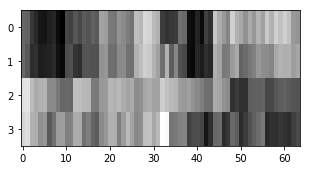

Training dataset
Mean Absolute Deviation:
Max: 5.61
Min: 4.32


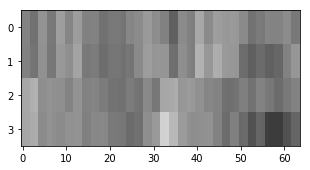

Generated dataset
Mean Absolute Deviation:
Max: 5.22
Min: 3.12


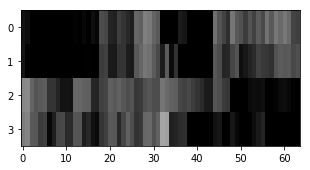

Graphs are normed to a min value of 3.8 and a max value of 6


In [0]:
calculateVariation(tunes_generated)
print("Training dataset")
calculateVariation(data, plotMin=3.8, plotMax=6)
print("Generated dataset")
calculateVariation(tunes_generated, plotMin=3.8, plotMax=6)
print("Graphs are normed to a min value of 3.8 and a max value of 6")

In [0]:
notefreq = {}
gennotefreq = {}

for dat in tunes_generated:
  
  if dat[-1][-2] in gennotefreq:
    gennotefreq[dat[-1][-2]] += 1
  else:
    gennotefreq[dat[-1][-2]] = 1
    
  if dat[-1][-4] in gennotefreq:
    gennotefreq[dat[-1][-4]] += 1
  else:
    gennotefreq[dat[-1][-4]] = 1
  
for dat in data:  
  
  if dat[-1][-2] in notefreq:
    notefreq[dat[-1][-2]] += 1
  else:
    notefreq[dat[-1][-2]] = 1
    
  if dat[-1][-4] in notefreq:
    notefreq[dat[-1][-4]] += 1
  else:
    notefreq[dat[-1][-4]] = 1


In [0]:

n = 0
o = 0
gn = 0
go = 0
    
print("In key:")
for k in range(tunes_generated.min(), tunes_generated.max()):
  if k in notes:
    if k in gennotefreq:
      print("\tGenerated: {}: {:.2f}%".format(notes[k], 50*gennotefreq[k]/tunes_generated.shape[0]))
      gn += 50*gennotefreq[k]/tunes_generated.shape[0]
    else:
      print("\tGenerated: {}: {:.2f}%".format(notes[k], 0))
    if k in notefreq:
      print("\tTraining:  {}: {:.2f}%".format(notes[k], 50*notefreq[k]/data.shape[0]))
      n += 50*notefreq[k]/data.shape[0]
    else:
      print("\tTraining:  {}: {:.2f}%".format(notes[k], 0))
    print("\n")

# print(gn,n)    
    
print("Not in key:")


for k in range(data.min(), data.max()):
  if k not in notes and (k in gennotefreq or k in notefreq):
    if k in gennotefreq:
      print("\tGenerated: {}: {:.2f}%".format(k, 50*gennotefreq[k]/tunes_generated.shape[0]))
      go += 50*gennotefreq[k]
    if k in notefreq:
      print("\tTraining:  {}: {:.2f}%".format(k, 50*notefreq[k]/data.shape[0]))
      o += 50*notefreq[k]
      
# print(go/tunes_generated.shape[0], o/data.shape[0])

In key:
	Generated: G,: 0.00%
	Training:  G,: 0.00%


	Generated: A,: 0.00%
	Training:  A,: 0.24%


	Generated: B,: 0.10%
	Training:  B,: 0.30%


	Generated: C,: 0.00%
	Training:  C,: 0.00%


	Generated: D: 3.35%
	Training:  D: 10.24%


	Generated: E: 4.30%
	Training:  E: 2.87%


	Generated: F: 3.10%
	Training:  F: 2.01%


	Generated: G: 6.15%
	Training:  G: 1.89%


	Generated: A: 11.20%
	Training:  A: 8.54%


	Generated: B: 7.75%
	Training:  B: 7.50%


	Generated: C: 0.00%
	Training:  C: 0.37%


	Generated: d: 39.60%
	Training:  d: 31.28%


	Generated: e: 13.15%
	Training:  e: 8.05%


	Generated: f: 4.25%
	Training:  f: 7.13%


	Generated: g: 4.45%
	Training:  g: 4.27%


	Generated: a: 1.95%
	Training:  a: 5.12%


	Generated: b: 0.30%
	Training:  b: 1.34%


	Generated: c: 0.00%
	Training:  c: 0.00%


	Generated: d': 0.35%
	Training:  d': 2.56%


	Generated: e': 0.00%
	Training:  e': 0.18%


	Generated: f': 0.00%
	Training:  f': 0.18%


Not in key:
	Training:  58: 0.18%
	Training:  60:

In [0]:


def nums_to_abc(nums):
    chars = []
#     print(nums)
    for num in nums:
        if num in notes:
            chars.append(notes[num])
        elif num > 83:
            apostrophe_count = np.ceil((num - 83) / 12).astype(np.int32)
            apostrophe_count = np.asscalar(apostrophe_count)
            note = notes[num - 12*apostrophe_count]
            apostrophes = "".join(["'"] * apostrophe_count)
            chars.append(note + apostrophes)
        elif num < 60:
            comma_count = np.ceil((60 - num) / 12).astype(np.int32)
            comma_count = np.asscalar(comma_count)
            note = notes[num + 12*comma_count]
            commas = "".join([","] * comma_count)
            chars.append(note + commas)
        else:
            print("ya fucked up: {} not in notes".format(num))
            
    return chars
  
def tune_to_abc(tune):
  bars = [nums_to_abc(bar) for bar in tune]
  return bars

tunes = [tune_to_abc(tune) for tune in tunes_generated]

print("First 3 tunes")
print(tunes[:3])
# print(tunes[10])

First 3 tunes
[[['B', 'B', 'd', 'd', 'd', 'd', 'd', 'B', 'B', 'B', 'd', 'd', 'g', 'g', 'd', 'd', 'A', 'A', 'B', 'B', 'd', 'd', 'A', 'A', 'd', 'd', 'B', 'B', 'd', 'd', 'd', 'd', 'G', 'G', 'd', 'd', 'd', 'd', 'A', 'A', 'd', 'd', 'd', 'd', "d'", "d'", 'a', 'a', 'e', 'e', 'd', 'd', 'd', 'd', 'e', 'e', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd'], ['B', 'B', 'd', 'd', 'd', 'd', 'd', 'B', 'B', 'B', 'd', 'd', 'g', 'g', 'd', 'd', 'A', 'A', 'A', 'A', 'd', 'd', 'A', 'A', 'd', 'd', 'B', 'B', 'd', 'd', 'd', 'd', 'G', 'G', 'd', 'd', 'd', 'd', 'A', 'A', 'd', 'd', 'd', 'd', "d'", "d'", 'g', 'a', 'e', 'e', 'd', 'd', 'd', 'd', 'e', 'e', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd'], ['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'g', 'g', 'g', 'a', 'a', 'a', 'a', 'a', "d'", "d'", 'a', 'a', "d'", "d'", "d'", "d'", 'a', 'a', 'g', 'g', 'f', 'f', 'e', 'e', 'g', 'g', 'g', 'g', "d'", "d'", 'a', 'a', 'g', 'g', 'a', 'a', 'g', 'g', 'g', 'g', 'f', 'f', 'd', 'd', 'd', 'd', 'f', 'f', 'd', 'd', 'd', 'd', 'd', 'd', 'd', 'd'], ['a', 

In [0]:
cleantunes = []

for num, tune in enumerate(tunes):
  
  newtune = []
  
  for bar in tune:
    
    newbars = []
    
    # split bar into fourths
    
    for i in range(0, 64, 4):
      
      newbar = bar[i:i+4]
      compressed = []
      
      if i % 16 == 0 and i != 0:
        compressed.append("|")
      
      j = 0
      count = 1
      note = None
      
      while j < len(newbar):
        
        if note != newbar[j]:
          if count > 1:
            compressed.append(str(count))
            count = 1
          note = newbar[j]
          compressed.append(newbar[j])
        else:
          count += 1
        j += 1
      if count > 1:
        compressed.append(str(count))
      
      newbars.append("".join(compressed))
  
    newtune.append("".join(newbars))
    
  cleantunes.append("||".join(newtune))
  
print(cleantunes[:2])

["B2d2d3BB2d2g2d2|A2B2d2A2d2B2d4|G2d2d2A2d4d'2a2|e2d2d2e2d4d4||B2d2d3BB2d2g2d2|A4d2A2d2B2d4|G2d2d2A2d4d'2ga|e2d2d2e2d4d4||a4a4g3aa4|d'2a2d'4a2g2f2e2|g4d'2a2g2a2g4|f2d2d2f2d4d4||a4a4g2f2g2f2|b2a2d'4a2g2f2e2|g2a2d'2a2g2d'2a2g2|e2d2d2f2d4d4", "d4d2e2e4e4|f2gfd2g2e2f2fed2|d4d2e2e4e2d2|f2g2e2d2d4d4||d4d2e2e4e4|f3gd2g2e2f2e2d2|d4d2e2e4e2d2|fg3e2d2def2g4||a4b2g2a2d'2d'2a2|g4e2d2d2e2a2fe|e4e2f2a2g2g2e2|g4f2e2e2f2g4||a4b2g2abd'2d'2a2|g4e2d2d2e2a2b2|aba2g4gag2g2f2|g4e2d2d4d4"]


In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [0]:
import pandas as pd
df = pd.DataFrame({'tunes': cleantunes})
df.to_csv("clean_generated_tunes.csv")

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

files = ['clean_generated_tunes.csv', 'generator.h5', 'discriminator.h5', 'combined.h5']

for f in files:
  uploaded = drive.CreateFile({'title': f})
  uploaded.SetContentFile(f)
  uploaded.Upload()
  print('Uploaded file `{}` with ID {}'.format(f, uploaded.get('id')))

Uploaded file `clean_generated_tunes.csv` with ID 1T8O1SE6HjQFOckbrm3-V6-IWo2a5Vi_d
Uploaded file `generator.h5` with ID 1wV8mHt_hktmg_9820KwRJUgKogYgDuvZ
Uploaded file `discriminator.h5` with ID 1a9vmFOrqq6_MmqORbnCcs8IbEx3d3QZ9
Uploaded file `combined.h5` with ID 1D8o1BjiYeAKdQhIdjvyOC_yxThmAIygA


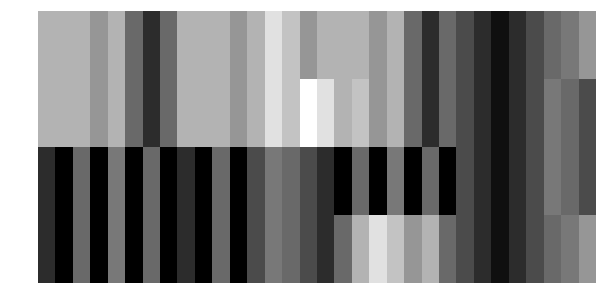

In [0]:
plt.figure(figsize=[10, 5])
plt.axis('off')
plt.imshow(data[np.random.randint(0, data.shape[0])], cmap='gray', aspect='auto')
plt.show()